In [51]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import  load_img
import zipfile
import os
from keras.layers import Dropout, Activation, Dense, Conv2D, Flatten, MaxPooling2D
from keras.models import Sequential, load_model
from google.colab import files
from keras.preprocessing import image

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [235]:
# melakukan unzip file dataset
local_zip = '/content/drive/My Drive/ai/chest_xray.zip'
zip_ref = zipfile.ZipFile(local_zip,'r')
zip_ref.extractall('/content')
zip_ref.close()

In [251]:
#menampung data train dan test
train_dir = 'chest_xray/train'
test_dir = 'chest_xray/test'

In [252]:
#Melihat class pneumonia dan normal pada folder train
train_pneumonia_dir = 'chest_xray/train/PNEUMONIA'
train_normal_dir = 'chest_xray/train/NORMAL'

print('jumlah gambar pneumonia : ', len(os.listdir(train_pneumonia_dir)))
print('jumlah gambar normal : ', len(os.listdir(train_normal_dir)))

jumlah gambar pneumonia :  3875
jumlah gambar normal :  1341


In [253]:
#Melihat class pneumonia dan normal pada folder test
test_pneumonia_dir = 'chest_xray/test/PNEUMONIA'
test_normal_dir = 'chest_xray/test/NORMAL'

print('jumlah gambar pneumonia : ', len(os.listdir(test_pneumonia_dir)))
print('jumlah gambar normal : ', len(os.listdir(test_normal_dir)))

jumlah gambar pneumonia :  390
jumlah gambar normal :  234


In [267]:
#pre-processing data
train_datagen = ImageDataGenerator(
                rescale = 1./255.,
                rotation_range = 20,
                width_shift_range = 0.1,
                height_shift_range = 0.1,
                shear_range = 0.1,
                zoom_range = 0.1,
                horizontal_flip = True
)

test_datagen = ImageDataGenerator(
                rescale = 1./255

)

In [268]:
train_generator = train_datagen.flow_from_directory(
                  train_dir,
                  batch_size = 32,
                  class_mode = 'categorical',
                  target_size = (150, 150)
)

test_generator = train_datagen.flow_from_directory(
                  test_dir,
                  batch_size  = 32,
                  class_mode  = 'categorical',
                  target_size = (150, 150),
                  shuffle = False
)

Found 5216 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [270]:
#melihat class data dn valuenya
print(train_generator.class_indices)
print(test_generator.class_indices)


{'NORMAL': 0, 'PNEUMONIA': 1}
{'NORMAL': 0, 'PNEUMONIA': 1}


In [263]:
# fungsi callback
akurasi_thr = 0.95
class my_callback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs = None):
        if logs.get('accuracy') >= akurasi_thr:
            print('\nEpoch', epoch, '\nAkurasi telah mencapai = %2.2f%%' %(logs['accuracy']*100), 'training telah dihentikan.')
            self.model.stop_training = True

In [271]:
model1 = tf.keras.models.Sequential([

    tf.keras.layers.Conv2D(16, (3,3), activation='relu', input_shape=(150, 150, 3),name="L1"),
    tf.keras.layers.MaxPooling2D(2, 2),

    tf.keras.layers.Conv2D(32, (3,3), activation='relu',name="L2"),
    tf.keras.layers.MaxPooling2D(2,2),


    tf.keras.layers.Conv2D(64, (3,3), activation='relu',name="L3"),
    tf.keras.layers.MaxPooling2D(2,2),


    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu',name="dense1" ),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.25),

    tf.keras.layers.Dense(2, activation='sigmoid')
])

model1.summary()

Model: "sequential_19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 L1 (Conv2D)                 (None, 148, 148, 16)      448       
                                                                 
 max_pooling2d_76 (MaxPooli  (None, 74, 74, 16)        0         
 ng2D)                                                           
                                                                 
 L2 (Conv2D)                 (None, 72, 72, 32)        4640      
                                                                 
 max_pooling2d_77 (MaxPooli  (None, 36, 36, 32)        0         
 ng2D)                                                           
                                                                 
 L3 (Conv2D)                 (None, 34, 34, 64)        18496     
                                                                 
 max_pooling2d_78 (MaxPooli  (None, 17, 17, 64)      

In [272]:
# mengompile model dengan adam optimizer loss fuction categorical_crossentropy
model.compile(loss='categorical_crossentropy',
              optimizer=tf.optimizers.Adam(),
              metrics=['accuracy'])
model.summary()


Model: "sequential_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_72 (Conv2D)          (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d_72 (MaxPooli  (None, 74, 74, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_73 (Conv2D)          (None, 72, 72, 64)        18496     
                                                                 
 max_pooling2d_73 (MaxPooli  (None, 36, 36, 64)        0         
 ng2D)                                                           
                                                                 
 conv2d_74 (Conv2D)          (None, 34, 34, 128)       73856     
                                                                 
 max_pooling2d_74 (MaxPooli  (None, 17, 17, 128)     

In [274]:
#melatih model
history = model.fit(
    train_generator,
    steps_per_epoch = 20,
    epochs = 5,
    validation_data = test_generator,
    validation_steps = 1,
    verbose =1,
    callbacks = [my_callback()]

)

Epoch 1/5
20/20 [==============================] - 50s 2s/step - loss: 0.3525 - accuracy: 0.8375 - val_loss: 0.3941 - val_accuracy: 0.8438
Epoch 2/5
20/20 [==============================] - 51s 3s/step - loss: 0.3426 - accuracy: 0.8594 - val_loss: 0.4922 - val_accuracy: 0.6875
Epoch 3/5
20/20 [==============================] - 54s 3s/step - loss: 0.3378 - accuracy: 0.8266 - val_loss: 0.5545 - val_accuracy: 0.7812
Epoch 4/5
20/20 [==============================] - 50s 2s/step - loss: 0.2423 - accuracy: 0.8938 - val_loss: 0.4567 - val_accuracy: 0.7188
Epoch 5/5
20/20 [==============================] - 50s 2s/step - loss: 0.3748 - accuracy: 0.8359 - val_loss: 0.3624 - val_accuracy: 0.8125


Saving person1946_bacteria_4874.jpeg to person1946_bacteria_4874 (11).jpeg
1/1 [==============================] - 0s 64ms/step
person1946_bacteria_4874 (11).jpeg
1
Hasil Prediksi : pneumonia


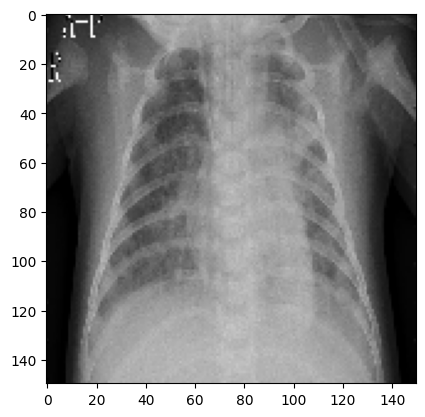

In [289]:
# mengunggah gambar
uploaded = files.upload()

# memprediksi gambar
for fn in uploaded.keys():
  path = fn
  img = image.load_img(path, target_size=(150,150))
  imgplot = plt.imshow(img)
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)

  images = np.vstack([x])
  classes = model.predict(images, batch_size=32)
  prediksi = np.argmax(classes)

  print(fn)
  print(prediksi)
  if prediksi == 0:
    print('Hasil Prediksi : normal')
  else:
    print('Hasil Prediksi : pneumonia')

In [282]:
#menyimpan model
model.save('model_deteksi_pneumonia.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [283]:
#melatih model
files.download('model_deteksi_pneumonia.h5')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>